In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import torch
import dataloader
import os
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

from action_utils import *

In [2]:
rgb_preds='record/spatial/spatial_video_preds.pickle'
with open(rgb_preds,'rb') as f:
    rgb =pickle.load(f)
    
opf_preds = 'record/motion/motion_video_preds.pickle'
with open(opf_preds,'rb') as f:
    opf =pickle.load(f)
    
stream = opf

In [3]:
dataloader = dataloader.spatial_dataloader(BATCH_SIZE=1, num_workers=1, 
                                           path='/mnt/disks/datastorage/videos/rgb/', 
                                           ucf_list='/home/mlp/two-stream-action-recognition/UCF_list/',
                                           ucf_split='01')
train_loader,val_loader,test_video = dataloader.run()

Spatial Dataloader Initialized
==> (Training video, Validation video):( 1837 403 )
==> sampling testing frames
Spatial train Dataset Initialized
==> Training data : 1837 frames
Spatial val Dataset Initialized
==> Validation data : 7657 frames


In [4]:
num_classes = 4

In [5]:
video_level_argmax = np.zeros(len(stream.keys()))
video_level_labels = np.zeros(len(stream.keys()))
video_level_preds = np.zeros((len(rgb.keys()), num_classes))

for ii, name in enumerate(sorted(stream.keys())):
    r = rgb[name]
    o = opf[name]

    label = int(test_video[name])-1

    fusion = r + o
    video_level_preds[ii,:] = fusion
    video_level_argmax[ii] = np.argmax(fusion)
    video_level_labels[ii] = label
    
video_level_argmax = video_level_argmax.astype(np.uint8)

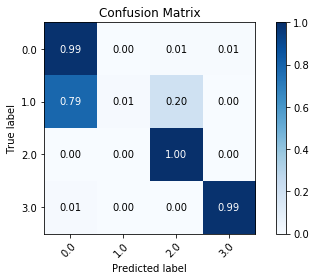

In [6]:
classes = set(video_level_labels.tolist() + video_level_argmax.tolist())
assert len(classes) == num_classes

cm = confusion_matrix(video_level_labels, video_level_argmax)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

cmap = plt.cm.Blues
title = 'Confusion Matrix'

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title=title,
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
plt.show()